In [1]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')
import warnings

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## 1. EDA

In [4]:
path = "./20_hw"

In [5]:
df_sample = pd.read_csv(path + "/sample_submission.csv")
df_sample.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [6]:
df_train = pd.read_csv(path + '/train.csv')
df_train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

### 1.1. Отделяем название картинки от предсказнной метки

In [7]:
df_train["label"] = df_train["Image_Label"].apply(lambda x: x.split("_")[1])
df_train["im_id"] = df_train["Image_Label"].apply(lambda x: x.split("_")[0])

df_sample["label"] = df_sample["Image_Label"].apply(lambda x: x.split("_")[1])
df_sample["im_id"] = df_sample["Image_Label"].apply(lambda x: x.split("_")[0])

In [8]:
df_train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

    label        im_id  
0    Fish  0011165.jpg  
1  Flower  0011165.jpg  
2  Gravel  0011165.jpg  
3   Sugar  0011165.jpg  
4    Fish  002be4f.jpg

In [9]:
df_sample.head()

Image_Label EncodedPixels   label        im_id
0    002f507.jpg_Fish           1 1    Fish  002f507.jpg
1  002f507.jpg_Flower           1 1  Flower  002f507.jpg
2  002f507.jpg_Gravel           1 1  Gravel  002f507.jpg
3   002f507.jpg_Sugar           1 1   Sugar  002f507.jpg
4    0035ae9.jpg_Fish           1 1    Fish  0035ae9.jpg

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
 2   label          22184 non-null  object
 3   im_id          22184 non-null  object
dtypes: object(4)
memory usage: 693.4+ KB


In [11]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14792 entries, 0 to 14791
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    14792 non-null  object
 1   EncodedPixels  14792 non-null  object
 2   label          14792 non-null  object
 3   im_id          14792 non-null  object
dtypes: object(4)
memory usage: 462.4+ KB


In [12]:
df_train['EncodedPixels'].isna()

0        False
1        False
2         True
3         True
4        False
         ...  
22179     True
22180     True
22181    False
22182     True
22183     True
Name: EncodedPixels, Length: 22184, dtype: bool

In [13]:
df_train['EncodedPixels'].isnull().any().sum()

1

In [14]:
df_train.dropna(subset = ['EncodedPixels'], inplace = True)  

In [15]:
df_train['EncodedPixels'].isnull().any().sum()

0

### 1.2. Уникальные значения классов

In [10]:
df_train.label.unique()

array(['Fish', 'Flower', 'Gravel', 'Sugar'], dtype=object)

### 1.3. Распределение данных по классам

In [19]:
df_train.iloc[:, 2].value_counts()

label
Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: count, dtype: int64

In [20]:
df_sample.iloc[:, 2].value_counts()

label
Fish      3698
Flower    3698
Gravel    3698
Sugar     3698
Name: count, dtype: int64

### 1.4. Посмотрим на картинки и маски

In [50]:
from PIL import Image

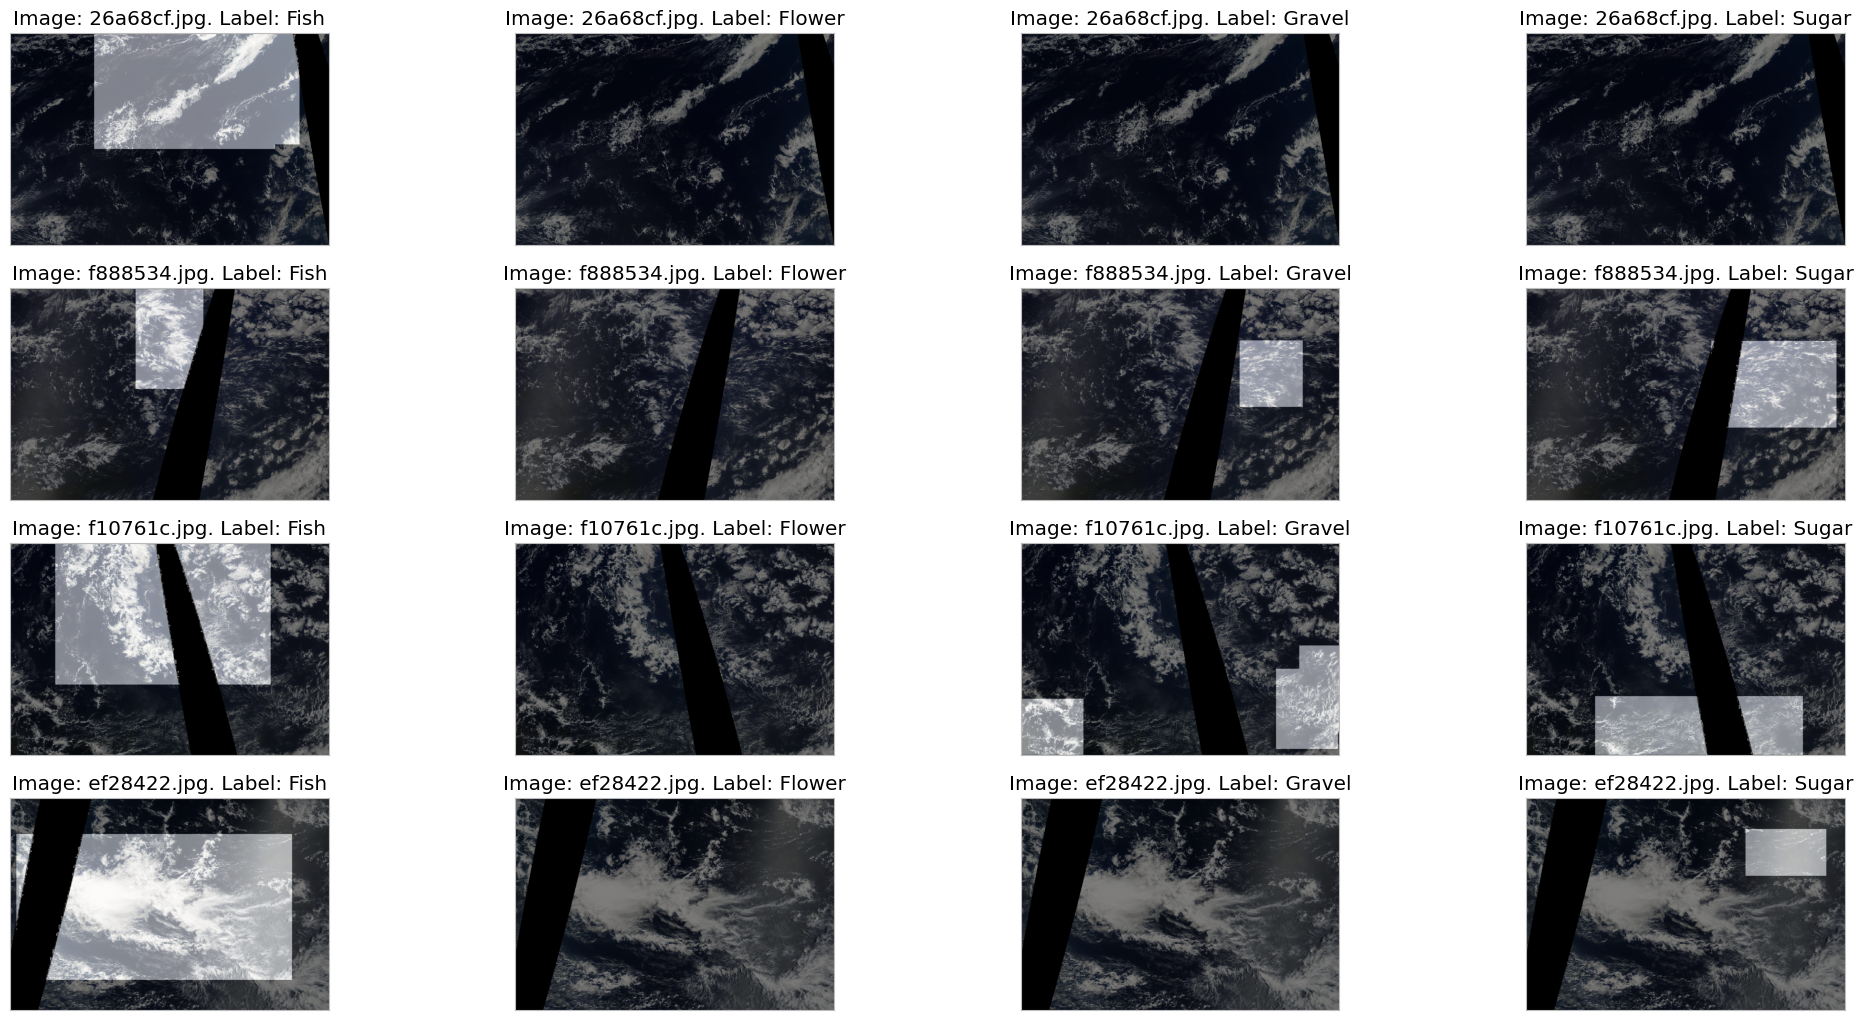

In [48]:
path_train_image = "./20_hw/train_images"
#path_train_image = "/content/cloud_img/train_images"
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(df_train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(df_train.loc[df_train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{path_train_image}/{row['im_id']}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        # если метки нет в данных
        try:
            mask = rle_decode(mask_rle)            
        except:
            mask = np.zeros((1400, 2100)) 
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

## 2. Вспомогательные функции

In [9]:
def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.

    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")

def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):        
        if label is not np.nan:
            mask = rle_decode(label)          
            masks[:, :, idx] = mask

    return masks   

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype("float32")


def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

# ф-я для аугментации тренировочных данных(датасет входных данных + маска)
# производим трансформацию данных для приведедния в соответствующий формат и размер
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.GridDistortion(p=0.5),
        albu.Resize(350, 525),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)

# ф-я для аугментации данных(датасет входных данных + маска), предназначенных для валидации
# производим трансформацию данных для приведедния в соответствующий формат и размер
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(350, 525),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)

# ф-я обертка для трансформации картинки и маски
def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



## 3. Подготовка данных

In [11]:
# split data
id_mask_count = (
    df_train.loc[df_train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={ "Image_Label": "img_id"})
)


## 4. Датасет

In [12]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

In [13]:
path_dataset = "./20_hw"

In [14]:
path = "./20_hw"

train_on_gpu = torch.cuda.is_available()
SEED = 42
MODEL_NO = 0 # in K-fold
N_FOLDS = 10 # in K-fold
seed_everything(SEED)
os.listdir(path)

['ex',
 'input',
 'ml_prof_hw_20_3.ipynb',
 'ml_prof_hw_20_3_ts.ipynb',
 'sample_submission.csv',
 'test_images',
 'train.csv',
 'train_images',
 'understanding_cloud_organization.zip']

In [15]:
#### В датасете реализуем загрузку картинок как для обучения, так и для валидации и тестирования

In [16]:
# Dataset class
class ResearchCloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path_dataset}/train_images"
        else:
            self.data_folder = f"{path_dataset}/test_images"        
        self.img_ids = img_ids
        self.transforms = transforms

    def __getitem__(self, idx):
      
        image_name = self.img_ids[idx]      
        mask = make_mask(self.df, image_name)     
        image_path = os.path.join(self.data_folder, image_name)     
        img = cv2.imread(image_path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
        augmented = self.transforms(image=img, mask=mask)       
        img = np.transpose(augmented["image"], [2, 0, 1])       
        mask = np.transpose(augmented["mask"], [2, 0, 1])

        return img, mask

    def __len__(self):
        return len(self.img_ids)

## 5. Dice коэффициент

In [17]:
class CheckDiceLoss(nn.Module):
    __name__ = 'check_dice_loss'

    def __init__(self):
        super().__init__()
        self.smooth=1.0   

    def forward(self, y_pred, y_true):
        dims = (0,2)                
        intersection = torch.sum((y_pred * y_true))
        cardinality = torch.sum((y_pred + y_true))        
        score = (2.*intersection + self.smooth)/(cardinality + self.smooth)
        return abs(1. - score)

In [18]:
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = abs(2 * intersection / (union + eps))

    return dice

## 5. Делим данные на test, train, validation
### источником данных для тестирования является файл sample_submission.csv

In [19]:
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED, shuffle= True
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = df_sample["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['0011165.jpg' '002be4f.jpg' '0031ae9.jpg' '0035239.jpg' '003994e.jpg'].. with length 4991
validation set ['00498ec.jpg' '006bf7c.jpg' '008a5ff.jpg' '0146ef3.jpg' '01eecc1.jpg'].. with length 555
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


## 6. Создаем датасет и loader

In [20]:
bs = 8
train_dataset = ResearchCloudDataset(
    df=df_train,
    datatype="train",
    img_ids=train_ids,
    transforms=get_training_augmentation(),
)
valid_dataset = ResearchCloudDataset(
    df=df_train,
    datatype="valid",
    img_ids=valid_ids,
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs
)

## 7. Модель

In [ ]:
##### модель создавалсь с учетом того, что на выходе она должна выдать массив масок картинки
##### каждому элементу массива соответствует класс (облаков) - их всего 4
##### маска должна по размеру соответствовать размеру входящей картинки(шиина и высота), координаты, где есть вероятность, 
##### что находятся определенного типа облака должны быть отмечены 1, все остальное отмечены, как 0.
#### т.к. у нас размерность матрицы первоначально сужается, а нам надо вернуть размер(ширина, высота) той же матрицы, что и картинка,
#### то необходимо обратно увеличивать размерность матрицы,т.е. использовали ConvTranspose2d в последовательности unconvlayer
#### Также необходимо учесть, что  при увеличении размерности матрицы у нас между элементами массива появляются 0, которыми заполняются 
#### элементы массива, а значит , если у нас был массив 001111100, то после увеличения он может превратиться в 00001010101010000,
#### чтобы минимизировать появлением таких 0 между значимыми элементами, в последнем слое использовал сверточный слой, 
#### который бы мог заполнить другими значениями некоторые такие 0 

In [21]:
class ResearchCloudNet(nn.Module):

    def __init__(self, in_ch, out_ch):
         # вызов конструктора предка
        super(ResearchCloudNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки
        self.convlayer1 = nn.Sequential(
            #in_channels - глубина входного тензора
            #out_channels - число ядер свертки
            #kernel_size - размер ядра свертки (width * height)
            #padding - кол-во фиктивных пикселей, которые добавляются по краям
            nn.Conv2d(in_channels=in_ch, out_channels=64, kernel_size=3, padding=1),          
            #batch norm - нормализует карты активации батча между слояи так, чтобы тензоры в этом батче имели среднее 0 и стандартное отклонение 1
            nn.BatchNorm2d(num_features=64),           
            nn.ReLU(inplace=True),      
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.unconvlayer0 =nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 64, stride = 2, dilation = 1, output_padding = 1, padding = 1, kernel_size = 3),                
        )  


        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.unconvlayer1 =nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, stride = 2, dilation = 5, output_padding = 1, padding = 1, kernel_size = 3),           
        )  

        self.convlayer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
            
        self.unconvlayer2 =nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, stride = 2, dilation = (1, 1), output_padding = (1, 0), padding = (1, 1),
                               kernel_size = 2),   
        )

        self.convlayer5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=4, kernel_size=(4,2),  stride = 1, dilation = (1,1), padding = 1 ),
            nn.BatchNorm2d(num_features=4),   
        )            
    

    def forward(self, x):
        
        x = self.convlayer1(x)        
        x = self.convlayer2(x)        
        x = self.unconvlayer0(x)        
        x = self.convlayer3(x)        
        x = self.unconvlayer1(x)
        x = self.convlayer4(x)
        x = self.unconvlayer2(x)     
        x = self.convlayer5(x)
            
        return F.log_softmax(x,dim=1)        

## 8. Создаем модель, оптимизатор и dice loss

In [ ]:
# 3 - это RGB матрица картинки, являющейся входными данными сети
# 4 - матрица масок вероятности принадлежности картинки одному из классов. всего классов 4

In [22]:
model = ResearchCloudNet(3, 4).float()

In [23]:
criterion = CheckDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
path_model = "./model/saved_models_ex_20_1.st"

## 9. Обучение

In [ ]:
# каждая эпоха обучения в среднем длится три часа, поэтому решил ограничится 12 эпохами, чтобы показать динамику(задачи ДЗ и т.п.)
# но оптимальному на такой датасет целесообразно было бы использовать 32 эпохи.

In [24]:
# число эпох для обычения модели
n_epochs = 12
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
curr_loss = 0.0
valid_loss_min = np.Inf # track change in validation loss
#print('H')
for epoch in range(1, n_epochs+1):

    # loss-ы
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
        
    # устанавливаем модель на обучение    
    model.train()    
    bar = tq(train_loader, postfix={"train_loss":0.0})
    
    for data, target in bar:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()        
        optimizer.zero_grad()        
        output = model(data)       
        loss = criterion(output, target)        
        loss.backward()        
        optimizer.step()    
        # обновляем loss обучения
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
               
   
    # проверяем модель, выводим ее из обучения
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # предсказываем
            output = model(data)         
            # считаем loss батча
            loss = criterion(output, target)
            # обновляем средний loss 
            valid_loss += loss.item()*data.size(0)         
            dice_cof = dice_no_threshold(output, target).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # считаем средние loss-ы
   
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # сохраним модель, если loss на валидации уменьшается
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), path_model)
        valid_loss_min = valid_loss
    elif valid_loss > valid_loss_min and epoch > 10:
        print('Early stopping!\nStart to test process.')            
        break;       
    
    scheduler.step(valid_loss)

100%|██████████| 70/70 [07:27<00:00,  6.39s/it, valid_loss=0.163, dice_score=0.837]


Epoch: 1  Training Loss: 2796.802023  Validation Loss: 0.445431 Dice Score: 0.554569
Validation loss decreased (inf --> 0.445431).  Saving model ...


100%|██████████| 70/70 [07:06<00:00,  6.09s/it, valid_loss=0.0959, dice_score=0.904]


Epoch: 2  Training Loss: 2475.752593  Validation Loss: 0.419065 Dice Score: 0.580935
Validation loss decreased (0.445431 --> 0.419065).  Saving model ...


100%|██████████| 70/70 [07:17<00:00,  6.25s/it, valid_loss=0.0868, dice_score=0.913]


Epoch: 3  Training Loss: 2287.477743  Validation Loss: 0.397912 Dice Score: 0.602088
Validation loss decreased (0.419065 --> 0.397912).  Saving model ...


100%|██████████| 70/70 [07:15<00:00,  6.22s/it, valid_loss=0.0236, dice_score=0.976]


Epoch: 4  Training Loss: 2106.911722  Validation Loss: 0.342875 Dice Score: 0.657125
Validation loss decreased (0.397912 --> 0.342875).  Saving model ...


100%|██████████| 70/70 [07:06<00:00,  6.10s/it, valid_loss=0.0169, dice_score=1.02] 


Epoch: 5  Training Loss: 1969.482928  Validation Loss: 0.310020 Dice Score: 0.690376
Validation loss decreased (0.342875 --> 0.310020).  Saving model ...


100%|██████████| 70/70 [07:06<00:00,  6.10s/it, valid_loss=0.00204, dice_score=1]    


Epoch: 6  Training Loss: 1853.290516  Validation Loss: 0.289387 Dice Score: 0.710635
Validation loss decreased (0.310020 --> 0.289387).  Saving model ...


100%|██████████| 70/70 [07:07<00:00,  6.11s/it, valid_loss=0.026, dice_score=0.974] 


Epoch: 7  Training Loss: 1751.799869  Validation Loss: 0.291794 Dice Score: 0.708206


100%|██████████| 70/70 [07:13<00:00,  6.19s/it, valid_loss=0.00573, dice_score=0.994]


Epoch: 8  Training Loss: 1648.068422  Validation Loss: 0.259607 Dice Score: 0.741222
Validation loss decreased (0.289387 --> 0.259607).  Saving model ...


100%|██████████| 70/70 [07:19<00:00,  6.28s/it, valid_loss=0.113, dice_score=1.11]  


Epoch: 9  Training Loss: 1569.864738  Validation Loss: 0.242732 Dice Score: 0.763406
Validation loss decreased (0.259607 --> 0.242732).  Saving model ...


100%|██████████| 70/70 [07:34<00:00,  6.49s/it, valid_loss=0.0651, dice_score=1.07] 


Epoch: 10  Training Loss: 1487.410553  Validation Loss: 0.236906 Dice Score: 0.767105
Validation loss decreased (0.242732 --> 0.236906).  Saving model ...


100%|██████████| 70/70 [07:29<00:00,  6.43s/it, valid_loss=0.0967, dice_score=1.1]  


Epoch: 11  Training Loss: 1426.955719  Validation Loss: 0.233269 Dice Score: 0.770474
Validation loss decreased (0.236906 --> 0.233269).  Saving model ...


100%|██████████| 70/70 [07:14<00:00,  6.20s/it, valid_loss=0.0471, dice_score=1.05] 

Epoch: 12  Training Loss: 1354.109843  Validation Loss: 0.214364 Dice Score: 0.792295
Validation loss decreased (0.233269 --> 0.214364).  Saving model ...


## 10. Результаты

### 10.1. Сравнение loss-ов на обучении и проверке(валидации)

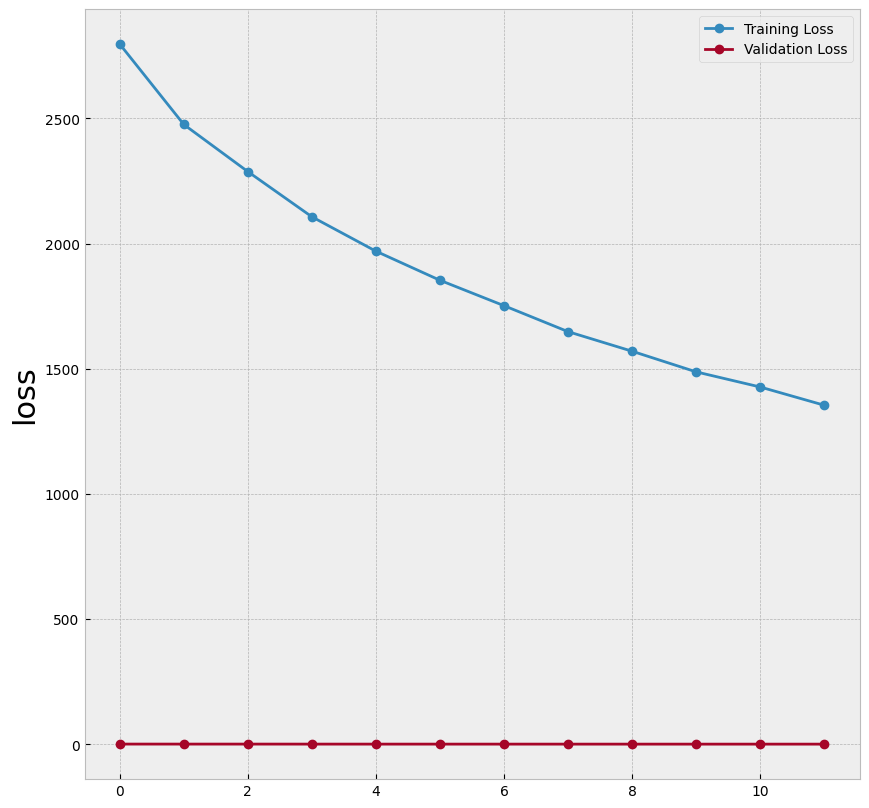

In [26]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

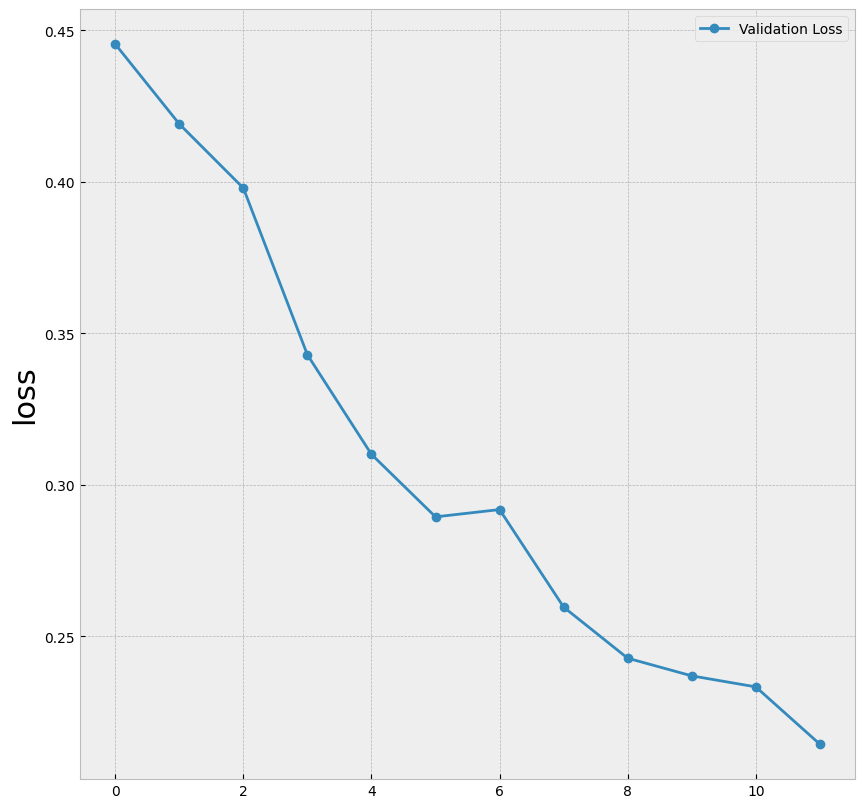

In [31]:
plt.figure(figsize=(10,10))
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

##### как мы видим, судя по динамике loss, можно сказать, что созданная модель имеет потенциал для улучшения.
##### Выше уже было описано, почему не было увеличено количество эпох.
##### Как мы видим по динамике, на 6 эпохе модель переобучилась, но затем справилась с этим и продолжила свое успешное обучение

### 10.2. Dice coefficient

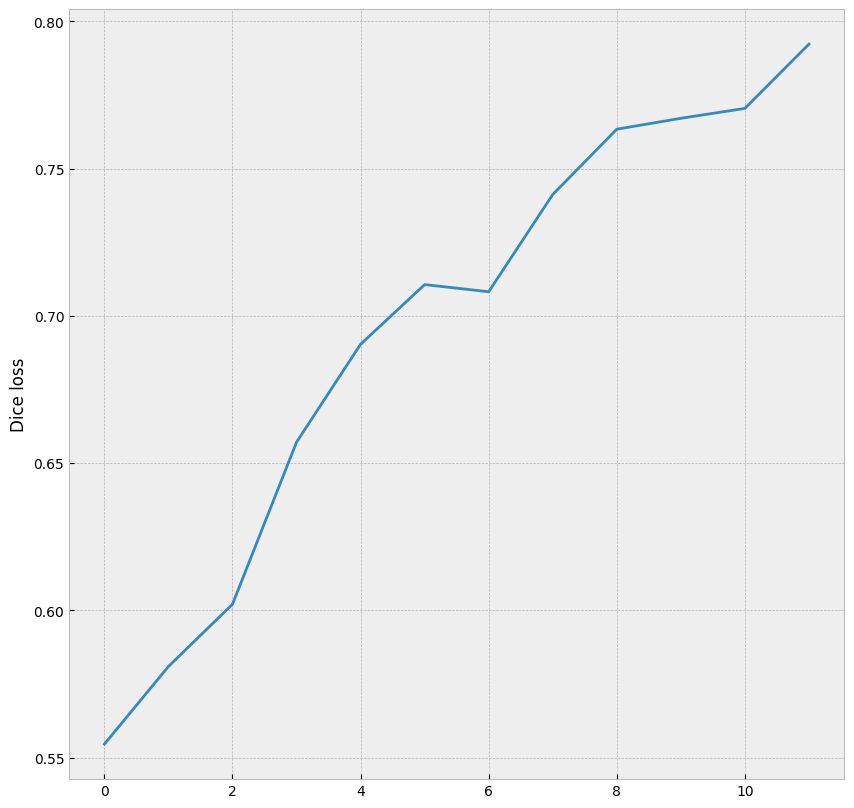

In [32]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice loss')
plt.show()

In [73]:
dice_score_list

[0.5545686680991371,
 0.5809346659763439,
 0.602087883261947,
 0.657125402463449,
 0.6903761157044419,
 0.7106348316948693,
 0.7082059387688164,
 0.7412217567632864,
 0.7634064618531649,
 0.7671050204887047,
 0.7704739450334429,
 0.7922952654125455]

In [ ]:
# коэффициент dice подтверждает, что модель достаточно хорошо обучается

### 10.3. Сравнение масок

In [ ]:
def resize_it(x):
    if x.shape != (350, 525):
        x = cv2.resize(x, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
    return x

##### Проверим визуально насколько точно отображается предсказанная маска сходится с действительной маской 

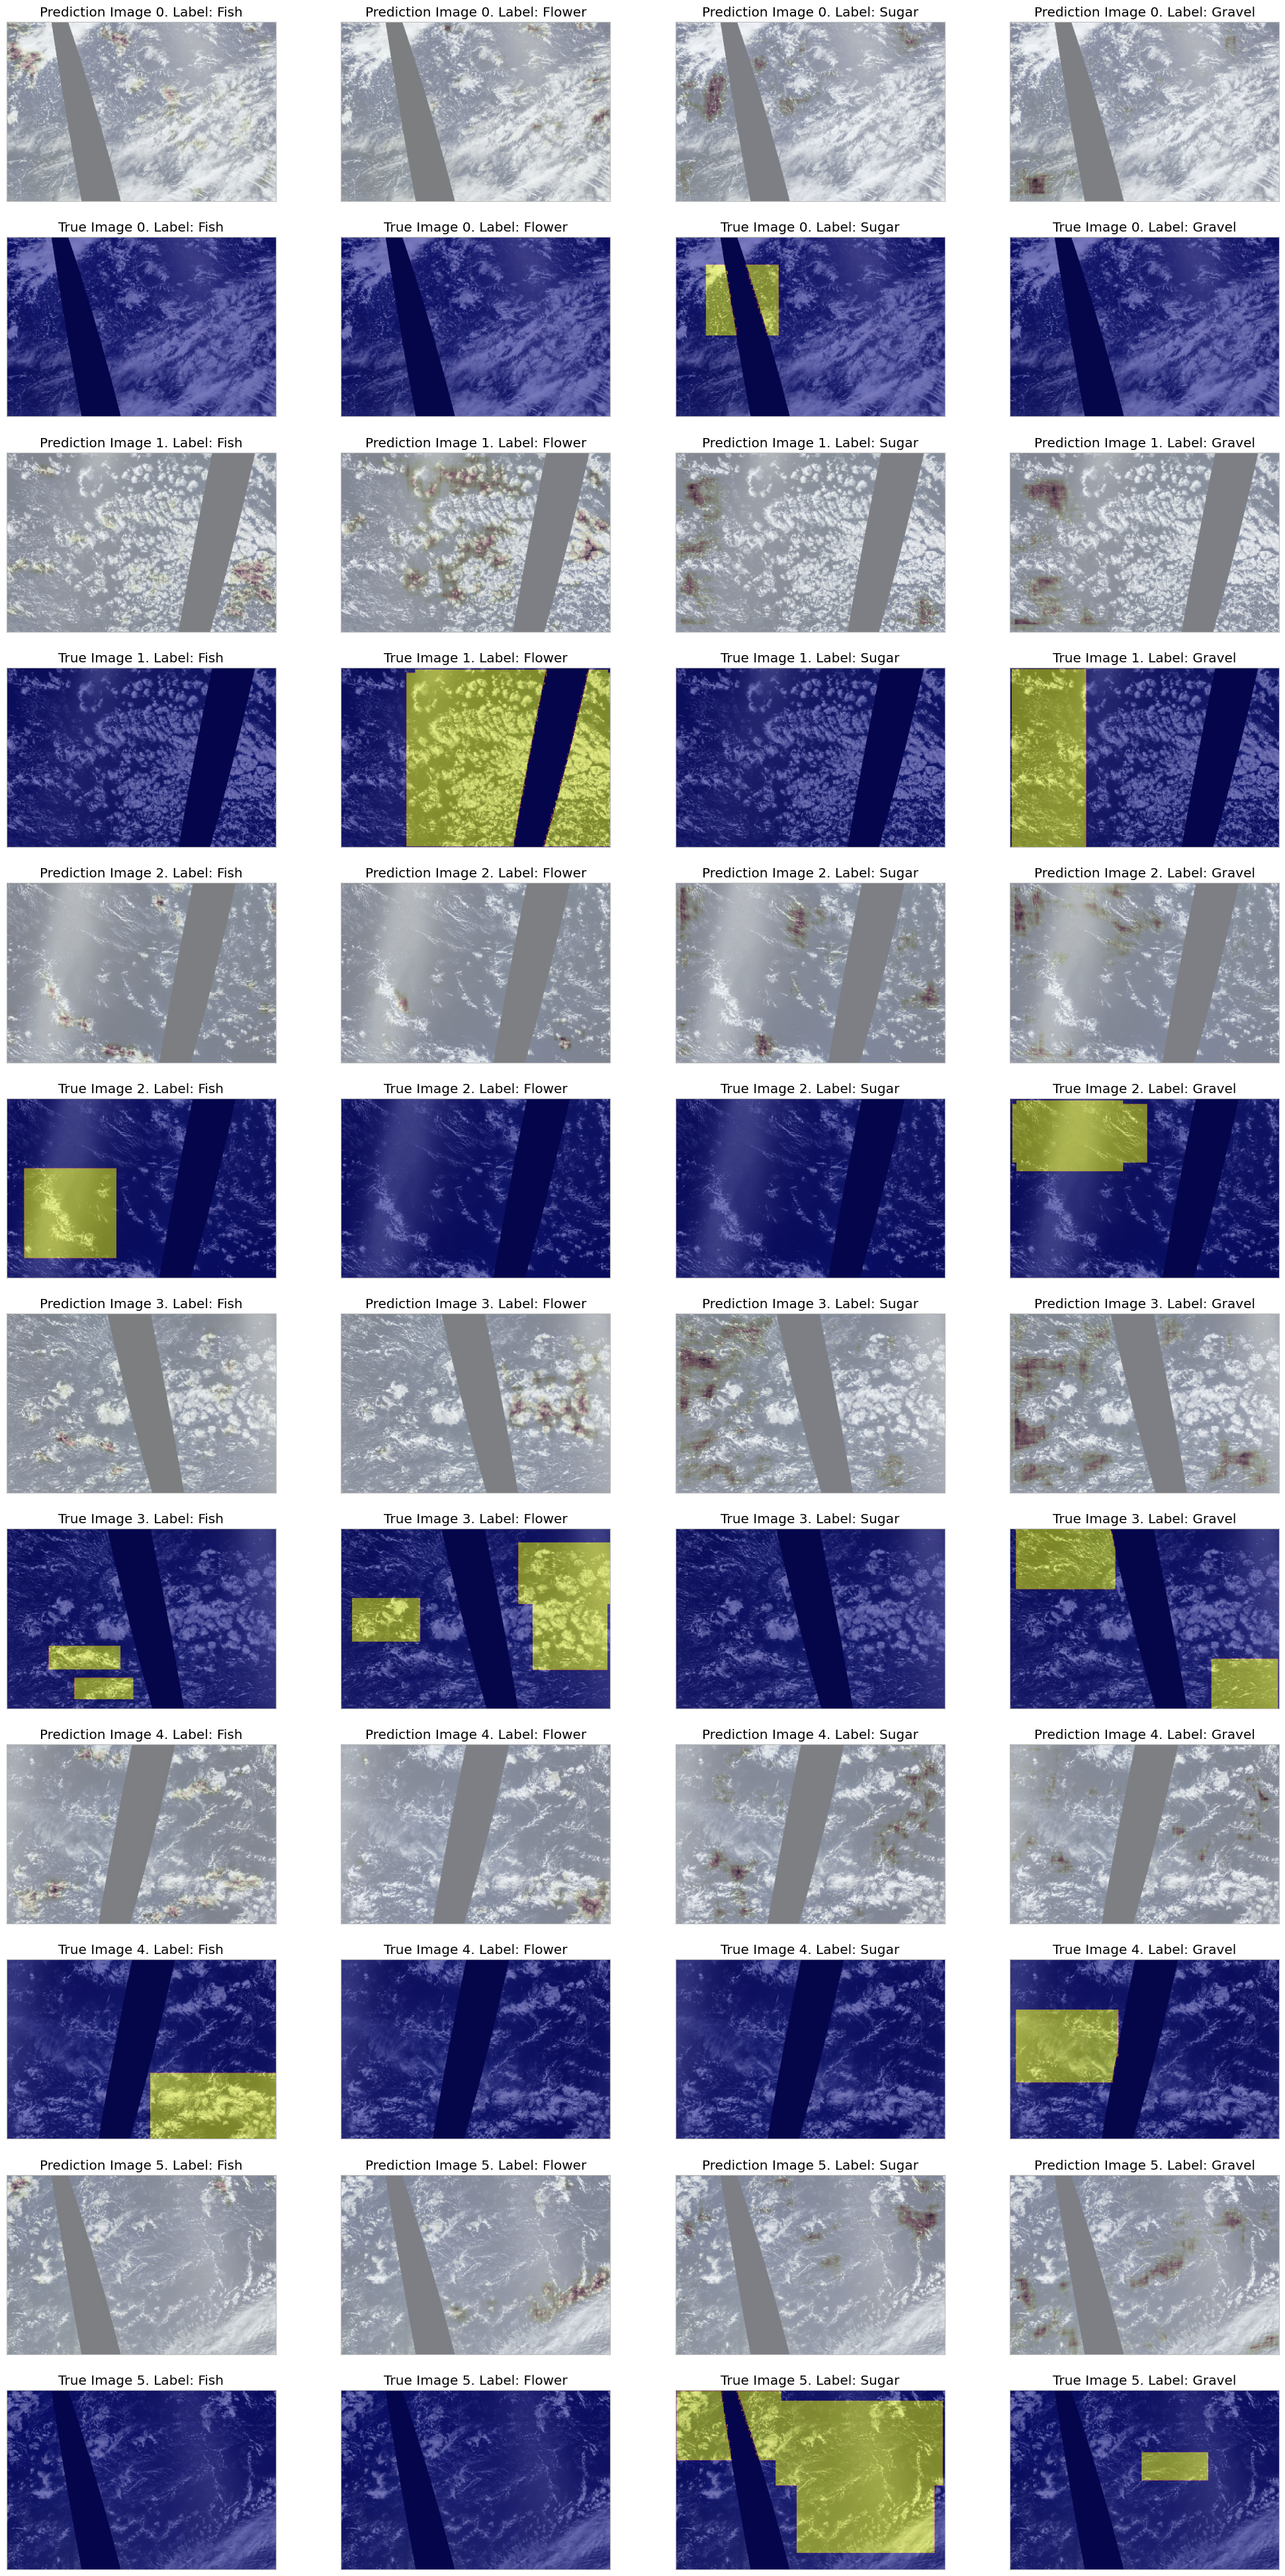

In [75]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
#модель выводим из обучения
model.eval()
# отклчаем подсчет градиентов 
torch.no_grad()
fig = plt.figure(figsize=(25, 50))
indx = 0;

# пробежимся по первым 5 картинкам из dataset-а и сравним маски
for i, (data, target) in enumerate(valid_loader):
    
    output_curr = (model(data))[0].cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()   
    output_curr = np.transpose(output_curr, [1, 2, 0])   
    img = np.transpose(image, [1, 2, 0])   
    masks = np.transpose(mask.astype('uint8'), [1, 2, 0])  

    #приведем 3 матрицы RGB к значениям [0..255], иначе возникнет предупреждение
    #Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
    img = ((img-img.min()) / (img.max()-img.min())) * 255
    img = Image.fromarray(img.astype(np.uint8))
     
    for j in range(4):
        ax = fig.add_subplot(12, 4, indx * 4 + j + 1, xticks=[], yticks=[])
        mask_pred = resize_it(output_curr[:, :, j])        
        plt.imshow(img)
        plt.imshow(mask_pred, alpha=0.5, cmap='pink')       
        ax.set_title(f"Prediction Image {i}. Label: {class_names[j]}")      
    indx += 1    
    
    for s in range(4):
        ax = fig.add_subplot(12, 4, indx  * 4 + s + 1, xticks=[], yticks=[])
        mask_true = resize_it(masks[:, :, s])        
        plt.imshow(img)
        plt.imshow(mask_true, alpha=0.5, cmap='plasma')        
        ax.set_title(f"True Image {i}. Label: {class_names[s]}")      
    indx += 1                
        
    if i == 5:
        break

##### как мы видим, предсказанная область масок во многом почти совпадает с действительными масками, что говорит о качестве созданной модели

## 11. Вывод

##### Удалось следующее:
##### 1) разобраться на практике с принципами определения определенных объектов на картинке
##### 2) создать такую сеть, которая бы по размерам сходилась с маской сравнения
##### 3) созданная модель при помощи корректно созданного loss имеет успешно обучаться и также выходить из переобучения
##### 4) приобрести знания в тонкости создания сети, чтобы она могла решать поставленную задачу
##### 5) в ходе работы пришлось хорошенько покопаться в матрице изображений 
##### 6) получить хорошую практику работы с матрицами (корректную работу) - не потерять значимые данные
##### 7) в добавок выполнил еще несколько задач по созданию сети для обнаружения вероятности тех или иных видов облаков на изображении, 
#####    правда в них не вычислялась маска, поэтому решил их не прикладывать, а так было тоже полезно.

##### От себя могу добавить: т.к. у меня были ограничения по используемой памяти, но, учитывая знания, которую нам дали на занятиях
##### (а что-то сам прочел в инете), + некоторые логических размышления позволили создать вполне хорошую сеть, если сравнить с другими на kaggle по
##### этой задаче.
##### Из чего напрашивается вывод: что очень важно грамотно подходить к настройке сети, его loss, хотя последнее примерно у всех был одинаковое.

##### Задача была очень интересной